<h1>Food Recognition</h1>
<h3>This is a basic project about image classification using tensorflow keras</h3>
In this course we will be exploring the use of tensorflow keras for image classification.

Image classification is the most common example that uses convolutional neural network.

The common application of such model will be in mobile applications and web applications to recognise objects.

Eg. A diet suggestion application, a medical consultation bot, etc.

We will implement this project from scratch and take small steps to ensure understanding.

<h3>Objectives:</h3>

1. Setting up environment
2. Select datasets
3. Dataset processing
4. Modeling
5. Training & Validation
6. Overfitting techniques
7. Optimal Learning_rates
8. Result deployment






<h3>Section 1: Setting Up Environment</h3>

**First we import the necessary packages needed, including tensorflow for neural network models, numpy for number processing and matplotlib for ploting**

**Use !pip install (package_name) if you do not have the packages**


**For this project, we are using Python 3.11.7, aloneside with the following packages:**

1. tensorflow = ^2.15.0
2. keras = ^2.15.0
3. tensorflow_datasets = ^4.9.4 
4. tensorboard = ^2.15.1
5. numpy = ^1.26.3
6. matplotlib = ^3.8.2
7. tensorflow_addons = ^0.23.0

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
import keras
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
import os

<h3>Section 2: Selecting Datasets</h3>

**The dataset we will be using is the "food101" dataset recorded tensorflow datasets.** 

**This dataset consists of the actual dataset as well as the information summary about it. The datasets have 101 food categories, with 101'000 images and every class is already splited into 250 manually reviewed test images as well as 750 training images. While the information page contains all the labels and feature infomation.**

**Labels are encoded with integers and more information can also be found in the dataset's infomation sheet**

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

**After downloading the datasets required, we may take a look at the infomation page to gain more insights about this data page.**

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/Users/chenyijie/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <S

**What we are interested in is the label dictionary in the information, as it helps us with decoding when we obtain a class prediction in the form of integer.**

In [4]:
label_dict = ds_info.features["label"].names
print(label_dict)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

<h3>Section 3: Data Processing</h3>

**Since the dataset already have the train test split, we will use it and seperate them into 2 different dataset.** 

In [5]:
train_ds, valid_ds = ds["train"], ds["validation"]

**We will then take alook at our images and their label.**

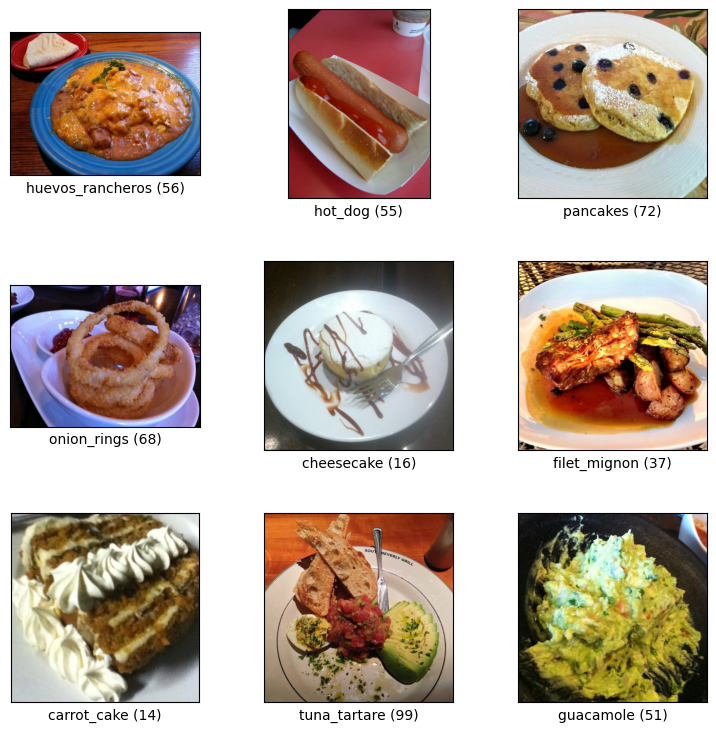

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

**As we can see, the images are in all different shap and sizes, thus we will standardise them into the same pixel size.**

In [6]:
MAX_SIDE_LEN = 256
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), label)
    )
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),label)
)

**Now we take a look again at the images to ensure that all images are of the same size.**

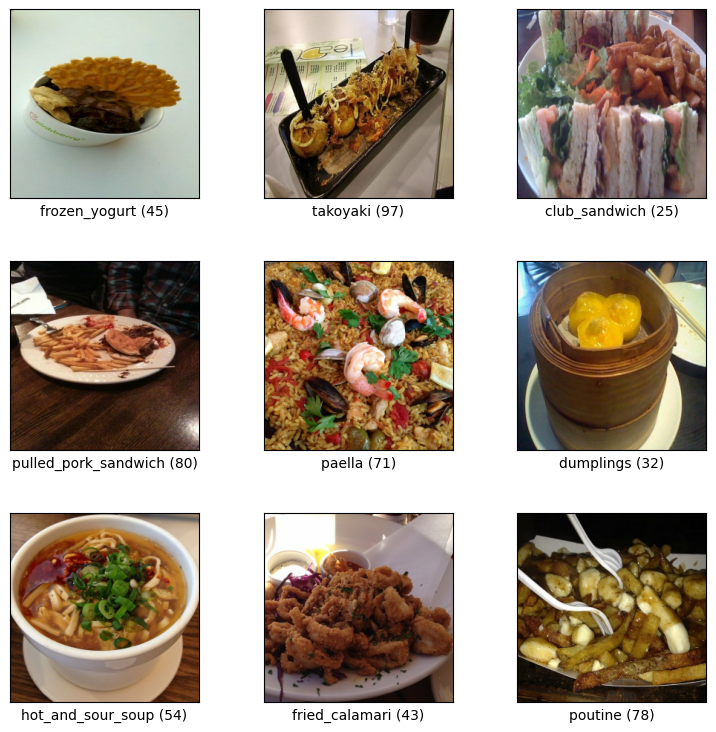

CPU times: user 744 ms, sys: 76.6 ms, total: 820 ms
Wall time: 303 ms


In [9]:
%%time
fig = tfds.show_examples(train_ds, ds_info)


<h3>Section 4: Modeling</h3>

**To start the training for our model, we must first decide a batch size.**

**Batch size determines how many samples are feed to the model to learn at once. A larger batch size means more data will be fed into the next update of the model, resulting in a smoother training curve. In exchange, larger batch sizes consumes more computational resources as well as slows down the training.**

**In this step, we strongly suggest choosing a batch size base on individual laptop's Random Access Memories(RAM)'s availabilty.**

**To fully utilise computational resources, we will task the computer to decide and bring future batches of data to set up a pipeline**

In [7]:
batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

**Now we will set up neural network by adding layers.** 

**To speed up training, we will introduce a method call transfer learning, taking a pre-trained neural network and add additional layers to customise the model to perform the specific class.**

**For this transfer learning, we will use Resnet-50, a model containing 50 layers trained by imagenet.**

**Since Resnet-50's parameters are trained, we do not wish to change the parameters. To introduce more trianable parameters, we can add more dense layers after the pretrained model and a classifying layer containing 101 nodes corresponding the 101 classes that we are classifying.**

In [6]:
Model = models.Sequential()
Transfer_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='avg', classes=101)
for layer in Transfer_model.layers:
    layer.trainable = False
Model.add(Transfer_model)
Model.add(layers.Dense(101, activation='softmax'))

**We then compile the model and check the summary, ensuring that the model is ready to be trained. In this case, we have over 1 million trainable parameters just from the 3 layers that we've added.**

In [7]:
Model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
Total params: 23794661 (90.77 MB)
Trainable params: 206949 (808.39 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


**We can plot our model using the util function to view the model structure**

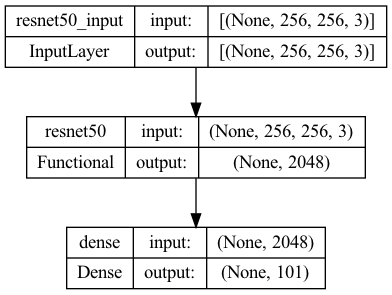

In [8]:
keras.utils.plot_model(Model, show_shapes=True)

<h3>Section 5: Training and validation</h3>

**To record the training of our model, we will use tensorboard. It auto logs the epochs and losses for our training and save the infomation in a local file.**

In [12]:
import tensorboard

**We can also utilise keras' inbuilt callbacks to record training data, or saving the best performing model.**

**Let us train the model for 15 epochs and see the performance**

In [10]:
import datetime
callbacks = [keras.callbacks.ModelCheckpoint(filepath='original_model.keras', save_best_only=True)]

epochs = 15
history = Model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  callbacks= callbacks
)
     

Epoch 1/15
4735/4735 [==============================] - 2261s 477ms/step - loss: 2.5097 - accuracy: 0.4234 - val_loss: 1.8602 - val_accuracy: 0.5406
Epoch 2/15
4735/4735 [==============================] - 2218s 468ms/step - loss: 1.8874 - accuracy: 0.5505 - val_loss: 1.8199 - val_accuracy: 0.5573
Epoch 3/15
4735/4735 [==============================] - 2219s 469ms/step - loss: 1.6431 - accuracy: 0.6034 - val_loss: 1.8530 - val_accuracy: 0.5605
Epoch 4/15
4735/4735 [==============================] - 2185s 461ms/step - loss: 1.4752 - accuracy: 0.6411 - val_loss: 1.9020 - val_accuracy: 0.5626
Epoch 5/15
4735/4735 [==============================] - 2216s 468ms/step - loss: 1.3480 - accuracy: 0.6717 - val_loss: 1.9562 - val_accuracy: 0.5613
Epoch 6/15
4735/4735 [==============================] - 2854s 603ms/step - loss: 1.2462 - accuracy: 0.6958 - val_loss: 2.0070 - val_accuracy: 0.5616
Epoch 7/15
4735/4735 [==============================] - 55280s 12s/step - loss: 1.1616 - accuracy: 0.7162 

**Let us plot the history of our training to have a clear visualisation of how our model improves.**

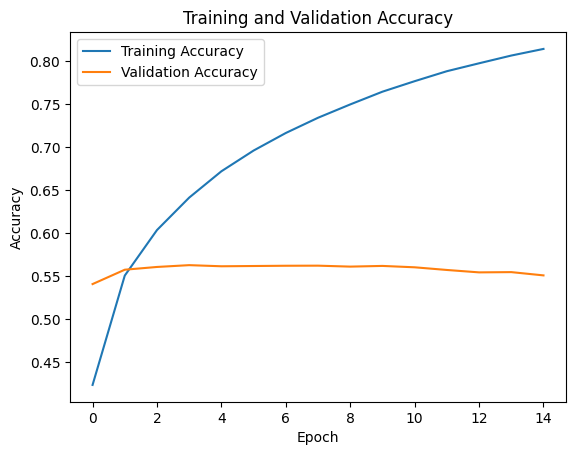

In [4]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.show()

**We can also save our model for distribution or future uses**

In [14]:
Model.save('food101_model.keras')
# new_model = keras.models.load_model('food101_model.keras')

<h3>Section 6: Overfitting Techniques</h3>

**From the training, we can see that while the training accuracy is going higher and higher, the validation accuracy actually decreases steadily**

**This is a very typical sign of overfitting.**

**Since the training data fed to the model during each epochs are the same, the computer tend to remember features of specific images too well and this results in the model doing better and better with test data and performing worse with validation data**

**To solve the problem of overfitting, we can perform some augmentation of data, as well as weight normalisation to ensure that every node contributes to the output of this neural network instead of one node having all the weights and thus solely deciding the outcome**

**Let us try to build another model**

**This time round, instead of adding layers behind the transfer model, we can add layers in front of the transfer model that randomly augment the images (Eg. flipping, rotation, zoom)**

**We will close the neural network by adding a dense layer to the end with softmax activation function to generate prediction**

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input

preprocess_model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.Lambda(preprocess_input)
])


updated_model = tf.keras.Sequential()

updated_model.add(preprocess_model)
updated_model.add(Transfer_model)
updated_model.add(layers.Dense(101, activation='softmax'))

updated_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



**Let us build and check the summary of our new model**

In [11]:
updated_model.build(input_shape=(None, 256, 256, 3))
updated_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 101)               206949    
                                                                 
Total params: 23794661 (90.77 MB)
Trainable params: 206949 (808.39 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


**We can also plot the model to see the structure**

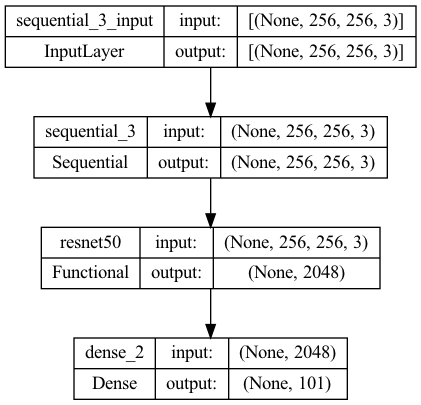

In [14]:
keras.utils.plot_model(updated_model, show_shapes=True)

**We can load our models from checkpoints in the case of something unexpected happens and interrupt our training**

In [13]:
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
updated_model.load_weights(checkpoint_path)

**Similarly, let us train the model, while having it to be saved to checkpoints whenever validation hits a highscore.**

In [14]:
import datetime
import os

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

history = updated_model.fit(
    train_ds,
    initial_epoch=0,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[tensorboard_callback, checkpoint_callback]
)


Epoch 1/10
4735/4735 [==============================] - ETA: 0s - loss: 2.4391 - accuracy: 0.4188
Epoch 1: val_accuracy improved from -inf to 0.58859, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 3665s 774ms/step - loss: 2.4391 - accuracy: 0.4188 - val_loss: 1.6165 - val_accuracy: 0.5886
Epoch 2/10
4735/4735 [==============================] - ETA: 0s - loss: 1.9251 - accuracy: 0.5240
Epoch 2: val_accuracy improved from 0.58859 to 0.62265, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 10528s 2s/step - loss: 1.9251 - accuracy: 0.5240 - val_loss: 1.4404 - val_accuracy: 0.6227
Epoch 3/10
4735/4735 [==============================] - ETA: 0s - loss: 1.7762 - accuracy: 0.5569
Epoch 3: val_accuracy improved from 0.62265 to 0.64143, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 9341s 2s/step - loss: 1.7762 - accuracy: 0.5569 - val_loss: 1.3554 - val_accuracy: 0.6414
Epoch 4/10
4735

In [25]:
hist_learning_rate = []
hist_val_accuracy = []
for i in range(10):
    hist_learning_rate.append(0.001)

hist_val_accuracy = history.history['val_accuracy']

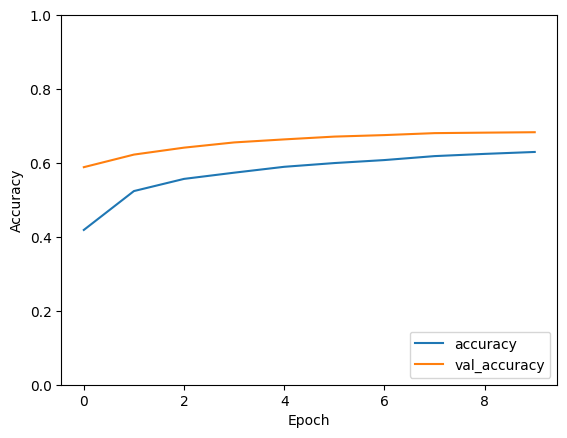

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

**We can use matplotlib to visualise the training history, showing the training loss and validation accuracy as a graph for us to better spot trend**

<h3>Section 7: Learning Rates</h3>

**Looking at the result visualisation, there is no longer a decreasing trend for our validation accuracy**

**That's good! Showing that we no longer have a problem of overfitting**

**To further increase our accuracy, we can explore different learning rates and observe the result**

**By specifying the "adam" optimiser, we can select the step size that the stochastic gradient descent update it's weights. This step size is called learning rate**

**The default learning rate of adam optimiser is 0.001, let us try a even lower learning rates and observe the effect**

In [20]:
import datetime
import os

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

updated_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = updated_model.fit(
    train_ds,
    initial_epoch=10,
    validation_data=valid_ds,
    epochs=15,
    callbacks=[tensorboard_callback, checkpoint_callback]
)


Epoch 11/15
4735/4735 [==============================] - ETA: 0s - loss: 1.3547 - accuracy: 0.6522
Epoch 11: val_accuracy improved from -inf to 0.68638, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 6325s 1s/step - loss: 1.3547 - accuracy: 0.6522 - val_loss: 1.1592 - val_accuracy: 0.6864
Epoch 12/15
4735/4735 [==============================] - ETA: 0s - loss: 1.3501 - accuracy: 0.6535
Epoch 12: val_accuracy improved from 0.68638 to 0.68721, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 4935s 1s/step - loss: 1.3501 - accuracy: 0.6535 - val_loss: 1.1575 - val_accuracy: 0.6872
Epoch 13/15
4735/4735 [==============================] - ETA: 0s - loss: 1.3478 - accuracy: 0.6531
Epoch 13: val_accuracy improved from 0.68721 to 0.68749, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 5919s 1s/step - loss: 1.3478 - accuracy: 0.6531 - val_loss: 1.1553 - val_accuracy: 0.6875
Epoch 14/15
4

In [27]:
for i in history.history['val_accuracy']:
    hist_val_accuracy.append(i)
    hist_learning_rate.append(1e-5)



**Observing the 5 training episode, we can see that validation accuracy do go up slightly during some of the episodes. Showing that the learning rate do have some effect in improving the model, but not optimal.**

**To estimate an optimal learning rate for our task, we can vary the learning rate used through out the training**

**Let us implement a learning rate scheduler and train the model for a few more episodes**

In [21]:
import datetime
import os

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
updated_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = updated_model.fit(
    train_ds,
    initial_epoch=15,
    validation_data=valid_ds,
    epochs=25,
    callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler]
)

Epoch 16/25
4735/4735 [==============================] - ETA: 0s - loss: 1.3652 - accuracy: 0.6477
Epoch 16: val_accuracy improved from -inf to 0.68974, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 2323s 490ms/step - loss: 1.3652 - accuracy: 0.6477 - val_loss: 1.1536 - val_accuracy: 0.6897 - lr: 5.6234e-05
Epoch 17/25
4735/4735 [==============================] - ETA: 0s - loss: 1.3565 - accuracy: 0.6500
Epoch 17: val_accuracy improved from 0.68974 to 0.69081, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 5511s 1s/step - loss: 1.3565 - accuracy: 0.6500 - val_loss: 1.1505 - val_accuracy: 0.6908 - lr: 6.3096e-05
Epoch 18/25
4735/4735 [==============================] - ETA: 0s - loss: 1.3551 - accuracy: 0.6485
Epoch 18: val_accuracy did not improve from 0.69081
4735/4735 [==============================] - 5760s 1s/step - loss: 1.3551 - accuracy: 0.6485 - val_loss: 1.1525 - val_accuracy: 0.6894 - lr: 7.0795e-05
Epo

In [29]:
for i in history.history['lr']:
    hist_learning_rate.append(i)

for i in history.history['val_accuracy']:
    hist_val_accuracy.append(i)

**Using the same matplotlib.pyplot library, we can plot the graph of training loss against episode numbers**

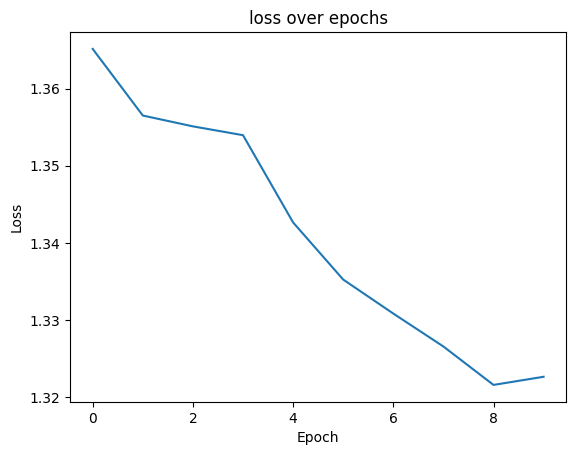

In [22]:
plt.plot(history.history['loss'])
plt.title('loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
np.save('hist_val_accuracy.npy', hist_val_accuracy)
np.save('hist_learning_rate.npy', hist_learning_rate)

**From the graph, we can observe that the training loss has the largest decrease from epoch 7 to epoch 8 (epoch 24 in our training)**

**We can now suspect that the training rate used at epoch 20 of our training is the most optimal**

**Let us train a few more episodes using the specific learning_rate to confirm our assumption**

In [33]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

updated_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=8.9125e-05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = updated_model.fit(
    train_ds,
    initial_epoch=25,
    validation_data=valid_ds,
    epochs=30,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 26/30
4735/4735 [==============================] - ETA: 0s - loss: 1.2281 - accuracy: 0.6782
Epoch 26: val_accuracy improved from -inf to 0.69683, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 2563s 541ms/step - loss: 1.2281 - accuracy: 0.6782 - val_loss: 1.1216 - val_accuracy: 0.6968
Epoch 27/30
4735/4735 [==============================] - ETA: 0s - loss: 1.2193 - accuracy: 0.6815
Epoch 27: val_accuracy did not improve from 0.69683
4735/4735 [==============================] - 2419s 511ms/step - loss: 1.2193 - accuracy: 0.6815 - val_loss: 1.1207 - val_accuracy: 0.6960
Epoch 28/30
4735/4735 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.6798
Epoch 28: val_accuracy did not improve from 0.69683
4735/4735 [==============================] - 2353s 497ms/step - loss: 1.2141 - accuracy: 0.6798 - val_loss: 1.1193 - val_accuracy: 0.6948
Epoch 29/30
4735/4735 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 

In [44]:
for i in history.history['val_accuracy']:
    hist_val_accuracy = np.append(hist_val_accuracy, i)
    hist_learning_rate = np.append(hist_learning_rate, 8.9125e-05)

In [52]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', mode='max')

updated_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = updated_model.fit(
    train_ds,
    initial_epoch=30,
    validation_data=valid_ds,
    epochs=40,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping]
)

Epoch 31/40


4735/4735 [==============================] - ETA: 0s - loss: 1.1574 - accuracy: 0.6957
Epoch 31: val_accuracy improved from -inf to 0.70028, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 2340s 494ms/step - loss: 1.1574 - accuracy: 0.6957 - val_loss: 1.1064 - val_accuracy: 0.7003
Epoch 32/40
4735/4735 [==============================] - ETA: 0s - loss: 1.1600 - accuracy: 0.6955
Epoch 32: val_accuracy improved from 0.70028 to 0.70048, saving model to checkpoints/model.ckpt
4735/4735 [==============================] - 2403s 507ms/step - loss: 1.1600 - accuracy: 0.6955 - val_loss: 1.1051 - val_accuracy: 0.7005
Epoch 33/40
4735/4735 [==============================] - ETA: 0s - loss: 1.1532 - accuracy: 0.6978
Epoch 33: val_accuracy did not improve from 0.70048
4735/4735 [==============================] - 2914s 616ms/step - loss: 1.1532 - accuracy: 0.6978 - val_loss: 1.1054 - val_accuracy: 0.7004
Epoch 34/40
4735/4735 [==============================] - ETA

In [53]:
for i in history.history['val_accuracy']:
    hist_val_accuracy = np.append(hist_val_accuracy, i)
    hist_learning_rate = np.append(hist_learning_rate, 1e-05)

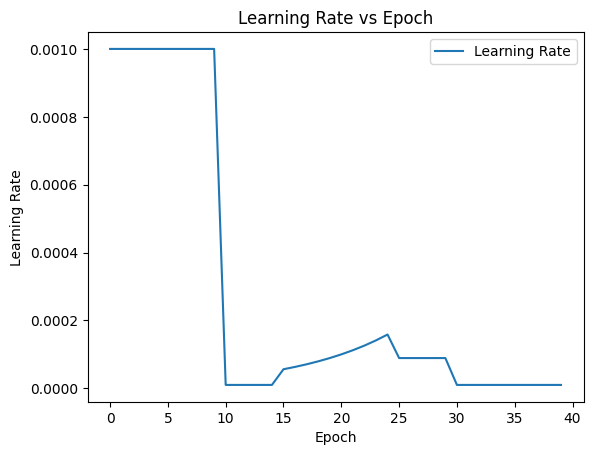

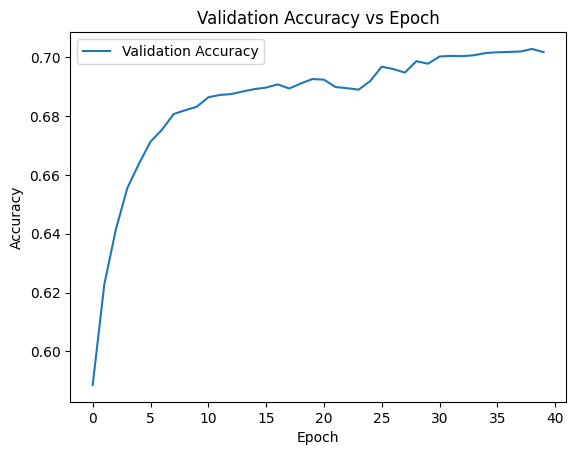

In [54]:
epochs = range(len(hist_val_accuracy))
plt.plot(epochs, hist_learning_rate, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epoch')
plt.legend()
plt.show()

plt.plot(epochs, hist_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()
plt.show()




In [55]:
updated_model.save('finalised_model.keras')

<h3>Section 8: Result Deployment</h3>

**To test out our model, we can find a random image from online, note that it has to be resized into the proper pixel count**

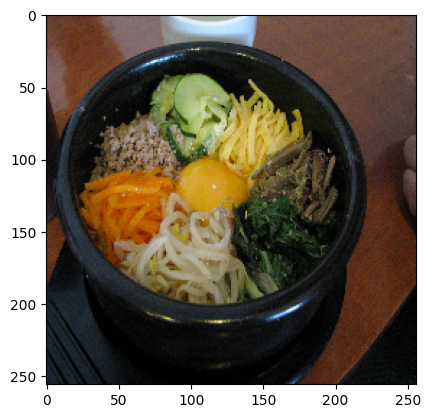

In [56]:
from skimage import io
img = io.imread('https://upload.wikimedia.org/wikipedia/commons/c/ca/Korean_cuisine-Bibimbap-01.jpg')
resized = tf.image.resize(img, (256,256))
plt.imshow(resized.numpy().astype(int))
plt.show()

**After expending the dimension of the resized image (since our model requires a batch size). We can proceed to run the resized image through our neural network and see the finalised prediction**

In [57]:
img = tf.expand_dims(resized, axis=0)
prediction = updated_model.predict(img)
predicted_label = label_dict[np.argmax(prediction)]
print("Predicted Label:", predicted_label)


1/1 [==============================] - 1s 971ms/step
Predicted Label: bibimbap


: 